In [3]:
import numpy as np
import numpy
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import matplotlib.pyplot as plt

mol = pyscf.gto.M(atom='N 0 0 0.; N 0 0 1.', basis='6-31G', verbose=3)
deltaZ = np.array((-0.05,-0.05))
includeonly = [0, 1]

calc = pyscf.scf.RHF(mol)

mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()/(1 / 0.52917721067), deltaZ)  
class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
                return (7+deltaZ[0])*(7+deltaZ[1])/(1/0.52917721067)
mf = NoSelfQMMM()
hfe=mf.kernel(verbose=4)
mycc = pyscf.cc.CCSD(mf).run()
print ('Energy:', mycc.energy() + hfe)

dm1 = mycc.make_rdm1()
dm1_ao = np.einsum('pi,ij,qj->pq', mf.mo_coeff, dm1, mf.mo_coeff.conj())
#dm1_ao=mf.make_rdm1()
for site in includeonly:
    # method A
    #q = mol._atm.copy()
    #q[site, 0] = 0
    #a = pyscf.gto.getints('int1e_nuc_sph', q, mol._bas, mol._env)
    #print ('EPN, method A', np.matmul(a, dm1_ao).trace() / mol.atom_charges()[site])
    # method B
    mol.set_rinv_orig_(mol.atom_coords()[site])
    print ('EPN, method B', np.matmul( dm1_ao,mol.intor('int1e_rinv')).trace())


converged SCF energy = -107.010579371823
E(CCSD) = -107.215386709503  E_corr = -0.2048073376795463
Energy: -107.21538670950301
EPN, method B 21.926152302753287
EPN, method B 21.92615230277287


In [4]:
#mf.scf()
### the problem is that the unrelaxed density matrix in ccsd is the same as 
##  Hartree Fock density matrix ( a part from a small numerical error)
print(mf.make_rdm1()-dm1_ao) 

[[ 1.08065133e-03 -3.27521333e-03 -4.57493922e-03 -1.28496347e-16
   3.91403248e-17  3.81355655e-03 -4.51403461e-17 -2.37233188e-18
  -2.05590235e-03 -1.62504271e-05 -2.10852426e-03  5.78232737e-03
   4.18654323e-17 -1.03420450e-17  2.68669078e-03  6.85967022e-17
  -2.21662097e-17 -2.95582076e-03]
 [-3.27521333e-03 -1.51062714e-02  3.46085412e-02  8.11644048e-17
  -7.51127440e-17 -1.39507198e-02 -2.43776765e-17 -4.12549078e-18
  -1.86392906e-03 -2.10852426e-03  7.73413138e-03 -3.26410862e-03
  -3.11452969e-16  2.71813139e-19 -9.51981551e-03 -2.66233259e-16
   3.54973046e-17  8.97095899e-03]
 [-4.57493922e-03  3.46085412e-02 -3.93283887e-02  3.50373103e-15
  -2.74761249e-17 -3.45538319e-02  1.66760657e-15  1.66087722e-16
  -5.16264076e-03  5.78232737e-03 -3.26410861e-03 -1.29601569e-03
   2.62597557e-15  3.21914015e-16 -2.74674753e-02  1.19844421e-15
   2.70357991e-16 -2.15337216e-02]
 [-1.28496347e-16  8.11644048e-17  3.50373103e-15 -3.60581518e-02
  -3.41553817e-16 -5.19184704e-16  4.

In [70]:
np.einsum('ij,ji',mycc.make_rdm1(),np.eye(18))

14.000000000000004

array([[ 0.00000000e+00,  1.38777878e-17,  1.38777878e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.77626358e-21, -3.46944695e-18,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  6.93889390e-18,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.38777878e-17,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.77555756e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.55111512e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.55111512e-17],
       [-1.38777878e-17,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -5.55111512e-17,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.11022302e

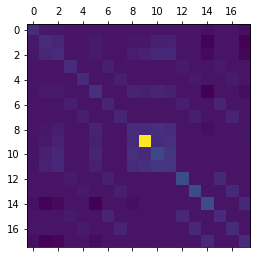

In [40]:
plt.matshow(mol.intor('int1e_rinv'))
mol.intor('int1e_rinv')-mol.intor('int1e_rinv').T

In [32]:
help(mol.set_rinv_orig_)

Help on method set_rinv_origin in module pyscf.gto.mole:

set_rinv_origin(coord) method of pyscf.gto.mole.Mole instance
    Update origin for operator :math:`\frac{1}{|r-R_O|}`.
    **Note** the unit is Bohr
    
    Examples:
    
    >>> mol.set_rinv_origin(0)
    >>> mol.set_rinv_origin((0,1,0))



In [28]:
mol.atom_coords()/(1 / 0.52917721067)

array([[0., 0., 0.],
       [0., 0., 1.]])

array([2.08510789, 0.50211401, 1.05217241, 0.42821792, 0.41463665,
       0.6641638 , 0.11165596, 0.17542803, 0.07905939, 2.08510789,
       0.50211401, 1.05217241, 0.42821792, 0.41463665, 0.6641638 ,
       0.11165596, 0.17542803, 0.07905939])

array([1.99993837, 1.99994299, 1.98899603, 1.97588856, 1.9476586 ,
       1.9476586 , 1.98092735, 0.04386803, 0.04386803, 0.00602777,
       0.00400162, 0.0059458 , 0.0059458 , 0.01215502, 0.00940992,
       0.00940992, 0.01007105, 0.00828655])

In [48]:
mol.intor('int1e_rinv')

array([[ 5.29177211e-01,  1.17591325e-01,  9.09491487e-02,
         0.00000000e+00,  0.00000000e+00,  2.30300834e-02,
         0.00000000e+00,  0.00000000e+00,  3.37425082e-03,
         5.75757734e-05,  2.32692260e-02,  4.51926896e-02,
         0.00000000e+00,  0.00000000e+00, -4.43854682e-02,
         0.00000000e+00,  0.00000000e+00, -7.43013701e-02],
       [ 1.17591325e-01,  5.28554613e-01,  4.06756179e-01,
         0.00000000e+00,  0.00000000e+00,  1.59269386e-01,
         0.00000000e+00,  0.00000000e+00,  1.01031049e-01,
         1.25363842e-01,  2.60412985e-01,  2.84327331e-01,
         0.00000000e+00,  0.00000000e+00, -2.99326727e-01,
         0.00000000e+00,  0.00000000e+00, -3.06615213e-01],
       [ 9.09491487e-02,  4.06756179e-01,  4.85888913e-01,
         0.00000000e+00,  0.00000000e+00,  1.48099628e-01,
         0.00000000e+00,  0.00000000e+00,  1.86327523e-01,
         2.82410294e-01,  4.12498415e-01,  4.46315998e-01,
         0.00000000e+00,  0.00000000e+00, -1.94712635e